In [1]:
import pandas as pd

In [2]:
import os; os.chdir("..")
import pqr
os.chdir("./examples/")


# Load and preprocess the data

In [3]:
prices = pd.read_csv("factors/russia/close_price.csv", parse_dates=True, index_col=0)["2003":].iloc[:-1]
pe = pd.read_csv("factors/russia/pe.csv", parse_dates=True, index_col=0)["2003":].iloc[:-1]
volume = pd.read_csv("factors/russia/trading_volume.csv", parse_dates=True, index_col=0)["2003":].iloc[:-1]
volume = prices * volume  # convert volume from lots to money

prices, pe, volume = pqr.utils.replace_with_nan(prices, pe, volume, to_replace=0)
prices, pe, volume = pqr.utils.align(prices, pe, volume)

# Define stock universe, prepare benchmark and make dashboard

In [5]:
universe = volume >= 1_000_000

benchmark = pqr.universe_as_benchmark(
    prices=prices,
    universe=universe,
)

In [10]:
table = pqr.utils.partial(
    pqr.metrics.show_table,
    metrics={
        "Monthly Mean Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_return,
            multiplier=100,
            statistics=True,
            annualizer=1,
        ),
        "Monthly Volatility, %": pqr.metrics.fancy_format(
            pqr.metrics.volatility,
            multiplier=100,
            annualizer=1,
        ),
        "Maximum Drawdown, %": pqr.metrics.fancy_format(
            pqr.metrics.max_drawdown,
            multiplier=100,
        ),
        "Sharpe Ratio": pqr.metrics.fancy_format(
            pqr.metrics.sharpe_ratio,
            rf=0,
        ),
        "Mean Excess Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_excess_return,
            multiplier=100,
            benchmark=benchmark,
        ),
        "Alpha, %": pqr.metrics.fancy_format(
            pqr.metrics.alpha,
            multiplier=100,
            benchmark=benchmark,
            statistics=True,
        ),
        "Beta": pqr.metrics.fancy_format(
            pqr.metrics.beta,
            benchmark=benchmark,
        ),
    }
)
chart = pqr.utils.partial(
    pqr.metrics.plot_chart,
    metrics={
        "Compounded Returns": pqr.metrics.compounded_returns,
    },
    benchmark=benchmark,
    figsize=(16, 9),
)

summary = pqr.utils.partial(
    pqr.metrics.display_dashboard,
    items=[table, chart]
)

# Build a factor model and analyse it

In [8]:
static_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.filter, universe=universe),
    pqr.utils.partial(pqr.look_back_median, period=3),
    pqr.utils.partial(pqr.hold, period=3),
)

value = static_transform(pe)

,Winners,Neutral 1,Losers,WML
"Monthly Mean Return, %",1.49*** (2.98),1.41*** (2.55),1.36*** (2.70),0.10 (0.27)
"Monthly Volatility, %",7.42,8.22,7.46,5.45
"Maximum Drawdown, %",-60.56,-75.43,-64.91,-68.84
Sharpe Ratio,0.70,0.59,0.63,0.06
"Mean Excess Return, %",0.96,-0.03,-0.63,-15.75
"Alpha, %",1.78 (0.65),-0.78 (-0.25),1.77 (0.48),2.66 (0.59)
Beta,0.95,1.04,0.86,-0.09


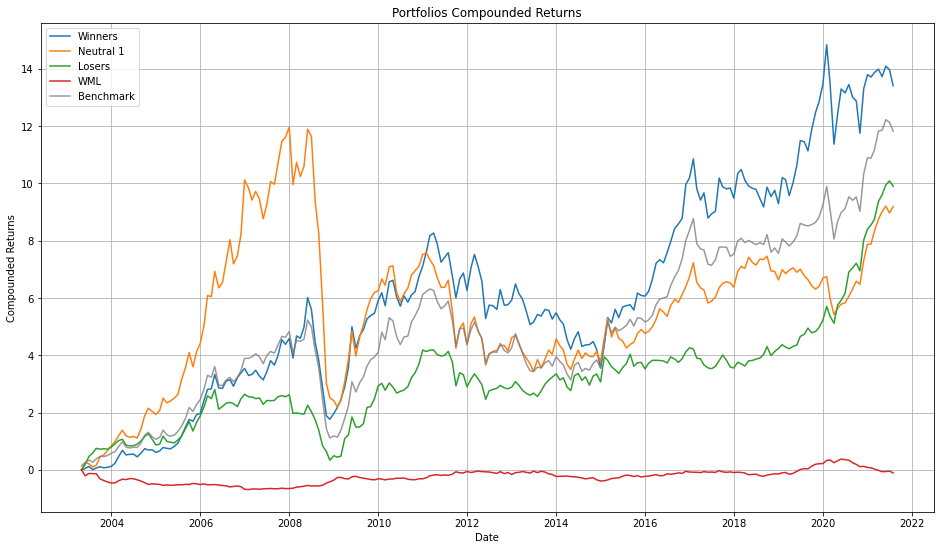

In [11]:
portfolios = pqr.backtest_factor_portfolios(
    factor=value,
    prices=prices,
    strategies=pqr.split_quantiles(3),
    allocation=pqr.equal_weights,
    add_wml=True,
)

summary(portfolios)